# Spatial Analysis

This notebook depends on the ImageProcessing and SingleCellAnalysis Notebooks to have been executed first! Be sure to do those notebooks before trying this one.

In [1]:
import os
import numpy as np
import pandas as pd
import palmettobug as pbug

The PalmettoBUG package is copyrighted 2024-2025 by the Medical University of South Carolina and licensed under the GPL-3 license.
It is free & open source software, can  be redistributed in compliance with the GPL3 license, and comes with absolutely no warranty.
In python, use palmettobug.print_license() to see the license, or use palmettobug.print_3rd_party_license_info() to print information
about the licenses and copyright of 3rd party software used in PalmettoBUG itself or in the creation of PalmettoBUG.


In [2]:
pbug.__version__

'0.2.11'

### CHANGE The following directory to match an existing directory on your computer if you are testing this tutorial on your own machine!

In [3]:
my_computer_path =  "C:/Users/Default/Desktop"  ## CHANGE This DIRECTORY to match an existing directory on your computer if you testing this tutorial on your own machine!

## Load a Previously made Analysis

The spatial module of the PalmettoBUG package requires that a single-cell analysis has already been loaded, and that that analysis has the information
on cell centroids and other spatial information (this should be automatically the case for the data generated through palmettobug itself for an imaging experiment). 
Of course, this cannot be done on a single-cell analysis derived from solution-mode data.

In the next couple of cells I load a project directory & Analysis directory previously created by other notebooks in the Core Pipeline tutorials. 
I also load a saved clustering (merging) from the analysis.

In [4]:
'''This cell contains the code to go from an already set up MCD project (as in, .tiff files and segmentation masks have already been generated in the expected folders) to an analysis
Normally, you may have already done the Analysis, and could go straight into setting up the SpatialAnalysis, but since these steps are separated into two notebooks in this example
we need to re-enter the project and create the Single Cell Analysis again.
'''

project_directory = f"{my_computer_path}/Example_IMC"
resolutions = [1.0, 1.0]    ## in micrometers. 1 micron is standard IMC resolution
ImageAnalysis = pbug.imc_entrypoint(project_directory, resolutions =  resolutions, from_mcds = False)

## Setup the analysis directory // set up the ImageAnalysis.directory_object for later access of critical directories
analysis_folder_name = "MyAmazingAnalysis"
ImageAnalysis.directory_object.make_analysis_dirs(analysis_folder_name)
input_img_folder = ImageAnalysis.directory_object.img_dir + "/img"
input_mask_folder = ImageAnalysis.directory_object.masks_dir + "/example_deepcell_masks"  ## for replicability with example masks. Also, 'deepcell', etc.

In [5]:
'''This cell contains the code to enter an already made analysis directory where a merging ('merging') has already been performed'''

Analysis_experiment = pbug.Analysis()
Analysis_experiment.load_data(ImageAnalysis.directory_object.Analysis_internal_dir) 


merging_name = 'merging'
Analysis_experiment.do_scaling("%quantile")    ## loading a saved clustering requires that the data matches, so the scaling of the data when the annotation was saved needs to be applied before loading the data.
                                               ## The data scaling can be changed after loading the clustering
Analysis_experiment.load_clustering(ImageAnalysis.directory_object.Analysis_internal_dir + f"/clusterings/{merging_name}.csv")

In [6]:
''' The spatial modules by default export plots to a predefined directory structure 
(in the folder ImageAnalysis.directory_object.Analysis_internal_dir + "/Spatial_plots"). 

Note that this newly created output_directory variable is not used anywhere in this notebook, it is only
here a helpful pointer to where to look for the exported plots if you are having difficulty finding them.'''

output_directory = ImageAnalysis.directory_object.Analysis_internal_dir + "/Spatial_plots"

## Set up SpatialAnalysis Class, and neighbor plots

The neighbor plots (interaction, enrichment, centrality) are essentially just wrappers on squipdy methods which operate on the underlying anndata object
inside the PalmettoBUG.Analysis and PalmettoBUG.SpatialAnalysis classes.

In [7]:
space_analysis = pbug.SpatialAnalysis()
space_analysis.add_Analysis(Analysis_experiment)
space_analysis.do_neighbors('Radius', 20)                 ## this runs the squidpy neighbors method, using the mask centroids

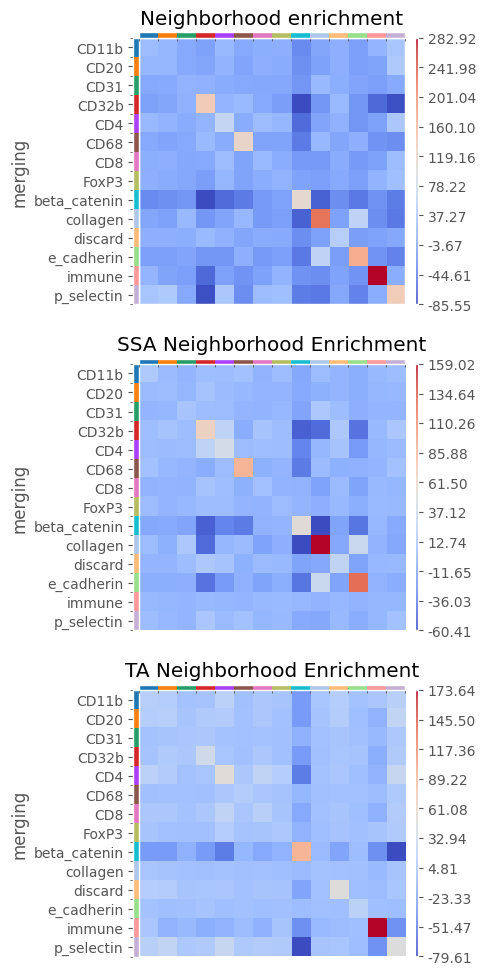

In [8]:
''' neighbor plots (each wraps a squidpy method: see squidpy's documenttion for more thorough details) --

1). Interaction plots. These show the raw number of interactions between cell types. However, this is sensitive to which cell types are the most common in the images

2). Neighborhood Enrichment plots. These use a permutation test to see if celltypes interact more than would have been expected by chance. The values of the heatmap
reflect z-scores of the difference between the expected number of interactions and the actually observed number of interactions. 

3). Centrality plots. These calculate various centrality statistics on the data. See squidpy documentation for more information. 

Interaction and Enrichment plots can be 'facetted' inside palmettobug. This effectively means that the data is subsetted into multiple anndata objects, grouping by the
unique values of the supplied facet_by column in the SpatialAnalysis.exp.data.obs dataframe (here, 'condition'). The first panel of a facetted plot is always the entire dataset's interaction/enrichment 
plot, but each subsequent panel shows that plot if only the data for that group is considered. This could be useful for comparing the association of the cell types across conditions. 

If filename is set to None (as in the examples), the plot is not written to the disk anywhere, only returned by the function.
'''
space_analysis.plot_neighbor_enrichment(clustering = "merging", facet_by = "condition", col_num = 1, seed = 42, n_perms = 1000, filename = "Neighborhood_enrichemnt")

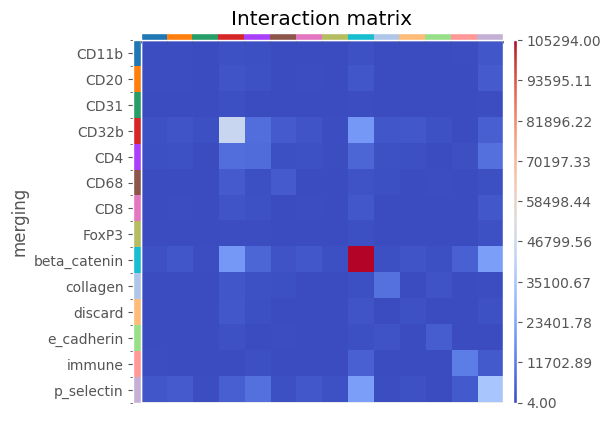

In [9]:
plot = space_analysis.plot_neighbor_interactions(clustering = "merging", facet_by = "None", filename = "Interaction_matrix")
plot

ERROR: Unable to fetch palette, reason: 'merging_colors'. Using `None`.


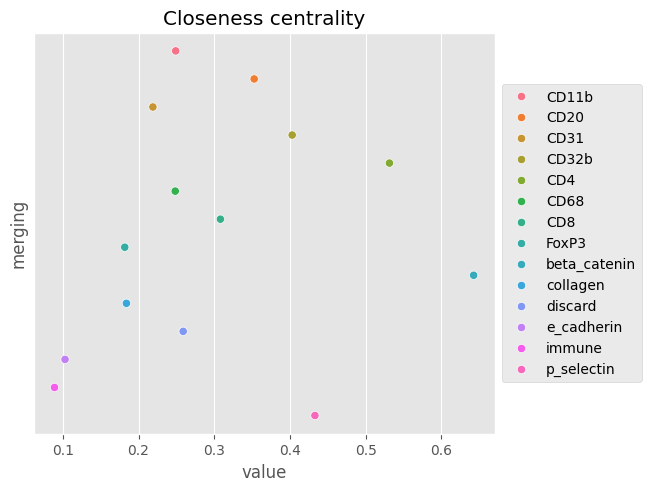

In [10]:
''' There are three kinds of centrality statistic -- see API documentation  / squidpy's centrality methods for more details '''
space_analysis.plot_neighbor_centrality(clustering = "merging", filename = "Closeness_centrality")

## Making Cell maps: Visualization cell types in their spatial context

These can either be with the format "points", where cells are represented as circles of varying sizes around their centroids, or as "masks" -- which uses
a squidpy method to display the cells' original segmentation shapes.

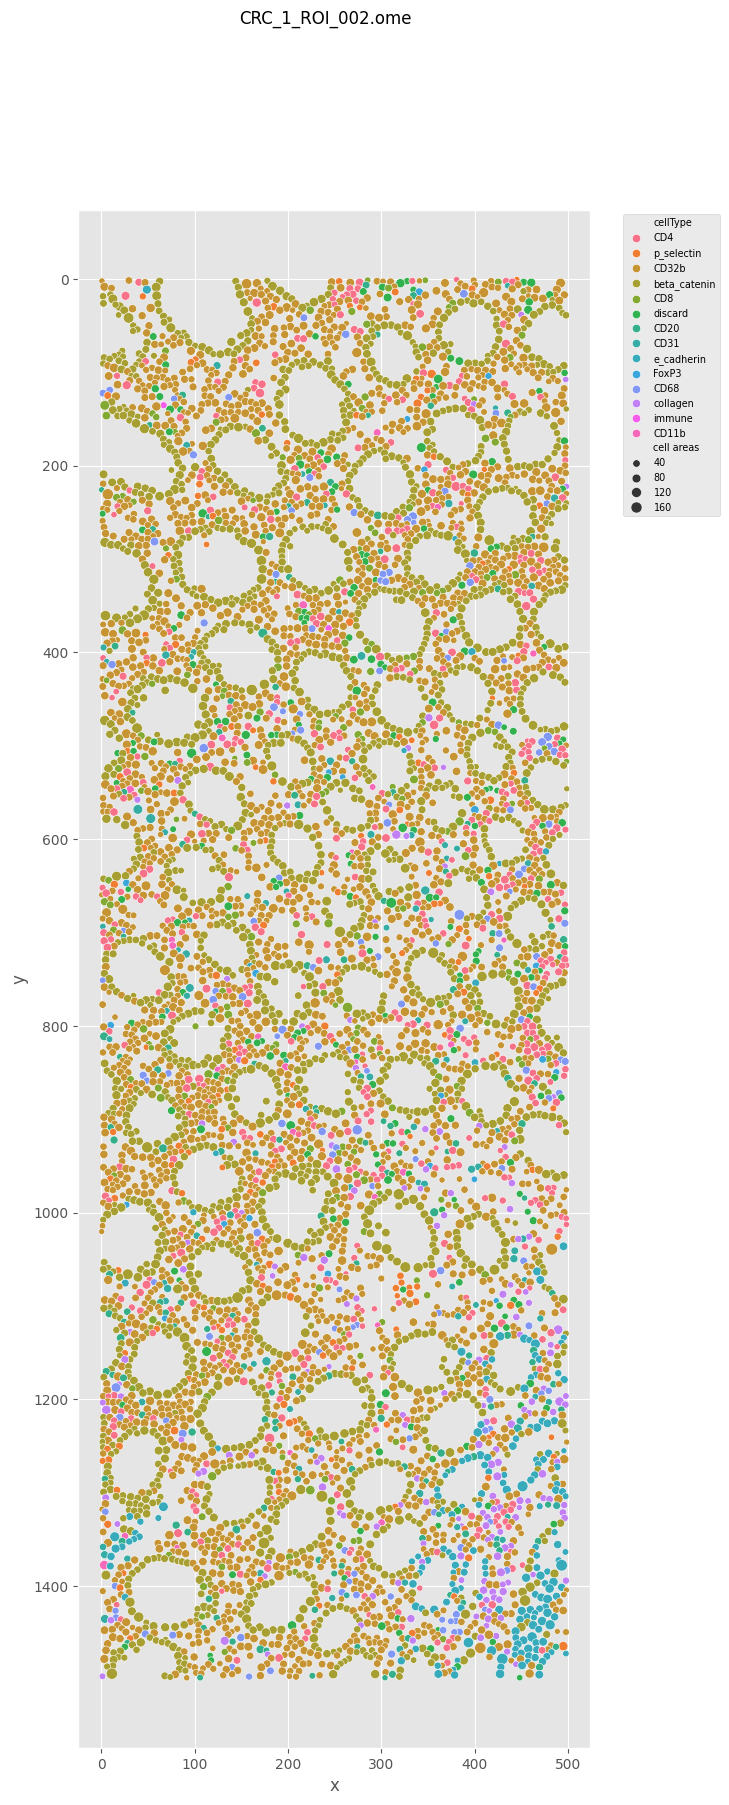

In [11]:
''' Note how the id parameter is the filename of the FCS file from which the single-cell data came from -- not the TIFF file!
This is because of how the SpatialAnalysis class is operating on an anndata object from an Analysis object, which is used for 
both imaging and solution mode experiments, and operates primarily with the FCS files.

Alternatively, you pass in a number (corresponding to the sample_id corresponding to that file in the metadata csv) instead of the filename.
This is used in the 'masks' example immediately after this to create a plot for this same image.
'''

plot = space_analysis.plot_cell_maps("points", clustering = 'merging', id = 'CRC_1_ROI_002.ome.fcs')  ### Note!!!  While it does return the figure as shown here, this function is also writing to the disk a copy of the figure
                                                                               ## The figure's filename is determined by the name of the image, so if plot_cell_maps is called again on the SAME image, it will OVERWRITE
                                                                               ## the copy of this figure on the disk. If you want to avoid overwriting and save multiple versions of the cell maps plots for a single image, 
                                                                               ## you need to save the new plot to a new location (using plot.savefig(_alternatefile_path) or similar), or manually rename / copy the old plot 
                                                                               ## into a new location before calling plot_cell_maps() for the second time
plot

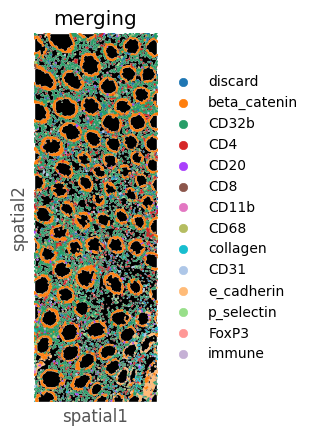

In [12]:
''' Note the parameter id ___________   '''

plot = space_analysis.plot_cell_maps("masks", id = '1')
plot

## Group Cells into Cellular Neighborhoods (CNs)

This clusters cells based on the celltype composition of their neighbors, using either FlowSOM or Leiden clustering.
Because these are unsupervised algorithms, annotation and merging is required afterwards to keep biologically relevant labels.

It adds a column to Analysis.data.obs and SpatialAnalysis.exp.data.obs, with the name 'CN' that contains the clustering numbers from the algorithm.
It also creates a plot -- a UMAP for leiden clustering, and a spanning tree plot for FlowSOM, which is returned as a figure. 

Here I do leiden clusteirng, although FlowSOM has the advantages of being faster to run allowing control over the final number of clusters -- which can 
be quite useful during annottaion / merging.

C:\Users\benca\miniforge3\envs\main\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Default\Desktop\PalmettoBUG\palmettobug\Analysis_functions\SpatialAnalysis.py:1288: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(new_anndata,


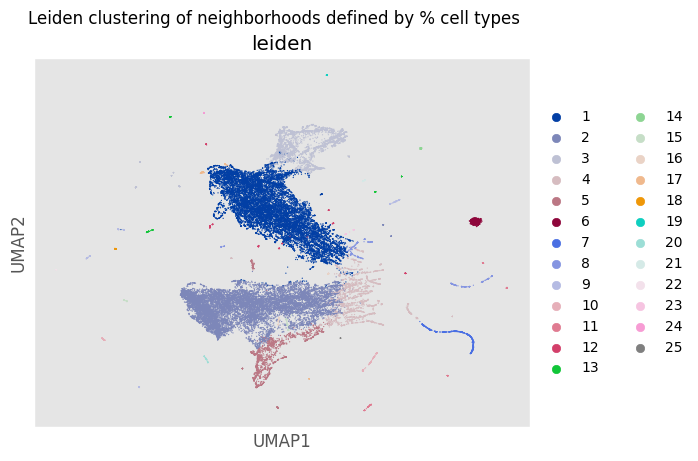

In [13]:
figure = space_analysis.do_neighborhood_CNs(clustering = "merging", 
                                              leiden_or_flowsom  = "Leiden",
                                              seed  = 42, 
                                              resolution  = 0.15, 
                                              min_dist  = 0.1, 
                                              n_neighbors  = 15,
                                           plot_filename = "Leiden_UMAP")
figure

In [14]:
space_analysis.exp.data.obs

,sample_id,file_name,patient_id,condition,merging,CN
0,0,CRC_1_ROI_001.ome.fcs,7139,SSA,discard,1
1,0,CRC_1_ROI_001.ome.fcs,7139,SSA,beta_catenin,1
2,0,CRC_1_ROI_001.ome.fcs,7139,SSA,beta_catenin,1
3,0,CRC_1_ROI_001.ome.fcs,7139,SSA,beta_catenin,6
4,0,CRC_1_ROI_001.ome.fcs,7139,SSA,beta_catenin,8
...,...,...,...,...,...,...
36922,9,CRC_3_ROI_004.ome.fcs,7139,TA,CD32b,2
36923,9,CRC_3_ROI_004.ome.fcs,7139,TA,CD11b,2
36924,9,CRC_3_ROI_004.ome.fcs,7139,TA,p_selectin,4
36925,9,CRC_3_ROI_004.ome.fcs,7139,TA,beta_catenin,6


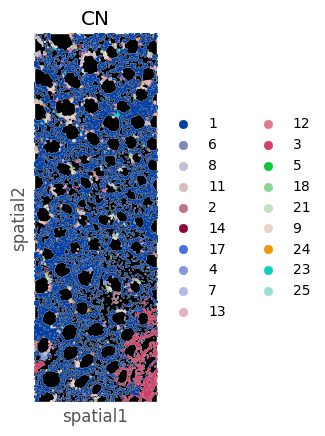

In [15]:
figure = space_analysis.plot_cell_maps('masks', id = '1',     
              clustering = "CN")
figure

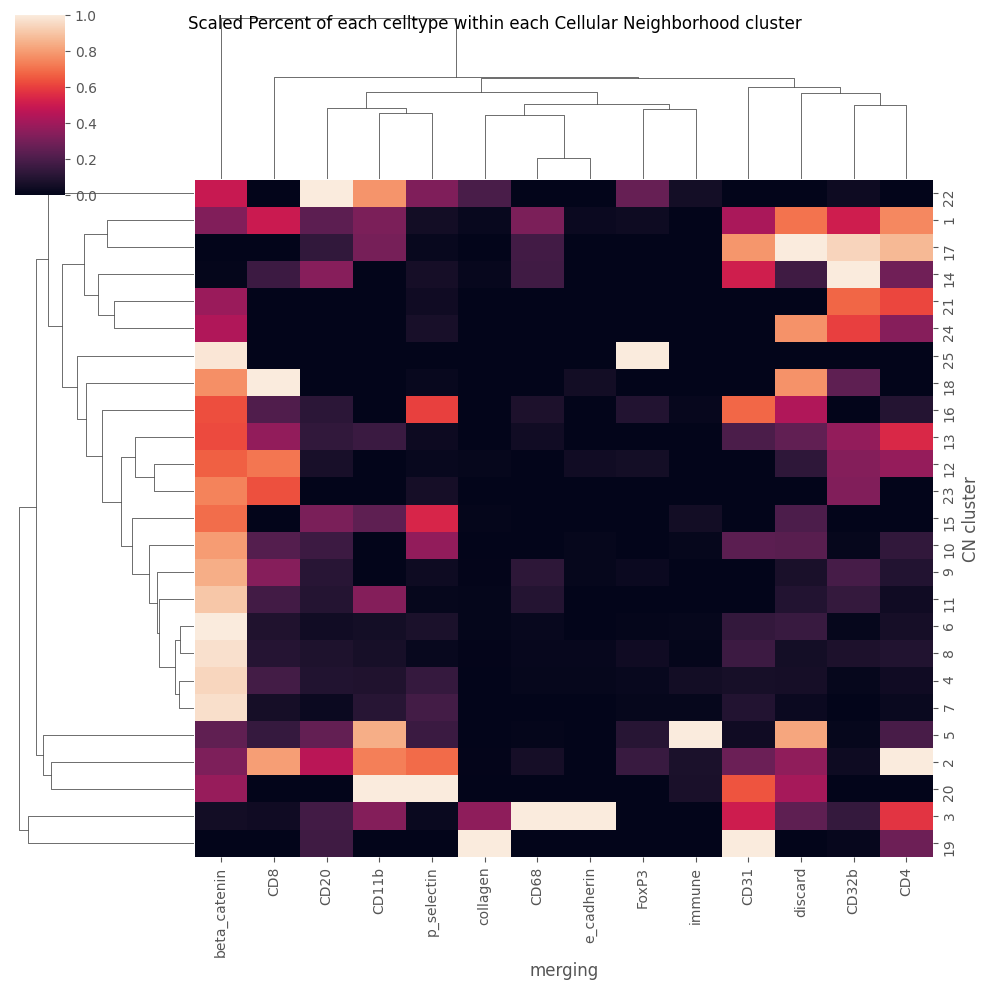

In [16]:
space_analysis.plot_CN_heatmap("merging")

In [17]:
space_analysis.exp.data.obs['CN']

0        1
1        1
2        1
3        6
4        8
        ..
36922    2
36923    2
36924    4
36925    6
36926    2
Name: CN, Length: 36927, dtype: int64

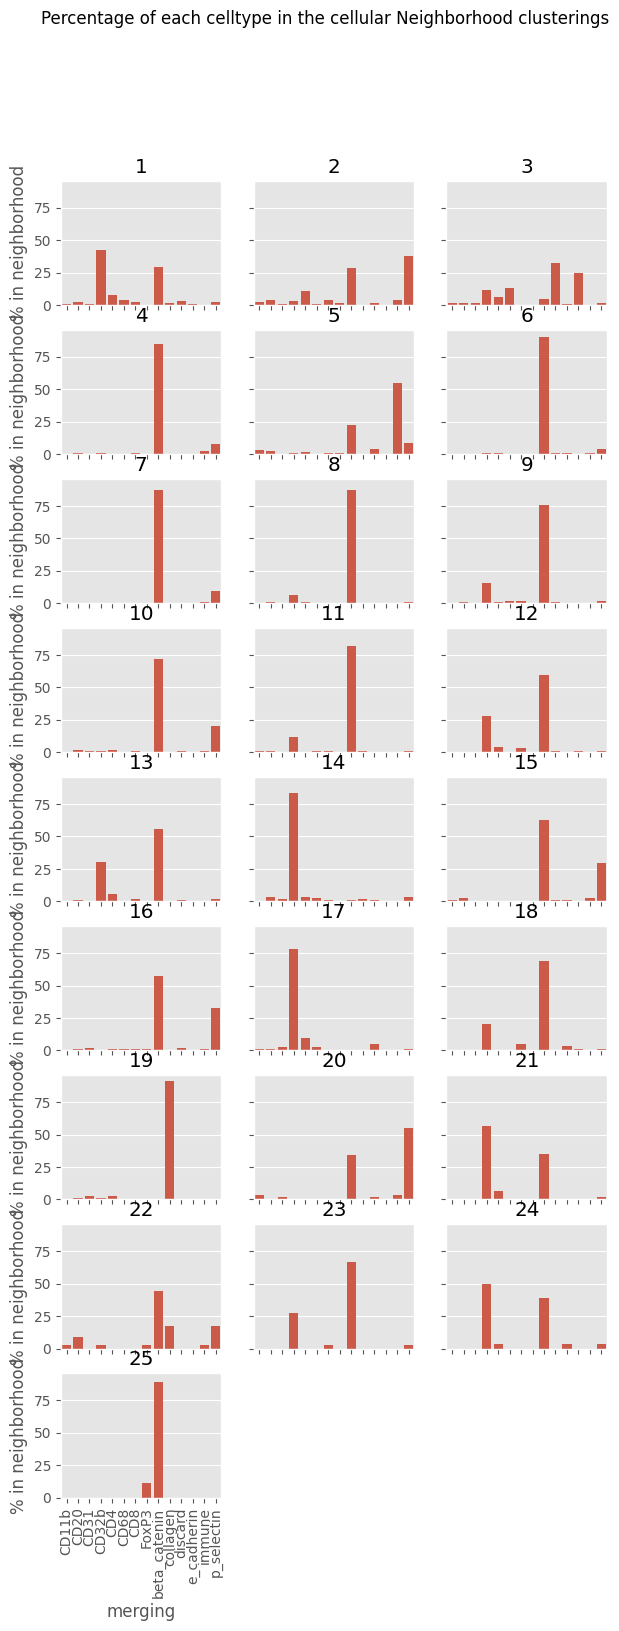

In [18]:
figure = space_analysis.plot_CN_abundance("merging")

## Ripley's Statistics and SpaceANOVA

SpaceANOVA works by calculating the celltype-to-celltype Ripley's statistics (K , L, and g) over a set of radii for every celltype--celltype pair in every image.
Then, those Ripley's statistics (usually g) can be treated as functions for the purposes of a functional ANOVA test. This allows the entire shape of the celltype--celltype
association to be used in the statistical comparison, and not a single selected radii.

To run, this method key parameters are:

    1). condition1 and condition2 --> these can be left blank (default = None for both) to do multi-comparisons, and get statistics looking at all conditions at once. Otherwise, two conditions in the 'condition' column of SpatialAnalysis.exp.data.obs should be provided to do a pairwise comparison

    2). celltype_key --> Ths is the column in SpatialAnalysis.exp.data.obs containing the cell type clustering (usually 'merging', but also could be 'metaclustering', 'leiden', 'classification', or a custom grouping)

    3). max, min, step --> These integers define the radii to examine. The radii can be seen using the python range object: range(min, max, step)

    4). threshold --> If the number of cells of a given celltype is less than this integer, than that celltype-celltype comparison will be ignored for that image, as in No Ripley's statistic will be calculated. Note that if ALL the images for a given condition(s) fails to meet this threshold for a given celltype, such that only one condition has data, then that celltype-celltype comparison will be dropped from the statistical analysis. 

    5). permutations --> If > 0, then a permutation correction of the data will be performed, using the number of permutations defined by this parameter. Permutation correction is almost always recommended as it corrects for the actual distribution of point in the data. However, it does slow the calculation. 


For other parameters, see the API documentation.

In [19]:
''' 
Some 'cell types' were very rare in this annotation and create a lot of extra warning messages when they fail to meet the threshold in an image -- I will drop them
to simplify the outputs.

WARNING! WARNING! WARNING! This step is very committal and affects all methods from the Analysis and SpatialAnalysis steps! If you only want to drop cell types for spaceANOVA,
you will want to either do spaceANOVA analysis last, or reload the single-cell Analysis afterwards to restore the dropped cells!
'''
Analysis_experiment.filter_data('discard', 'merging')
Analysis_experiment.filter_data('CD31', 'merging')
Analysis_experiment.filter_data('CD32b', 'merging')
Analysis_experiment.filter_data('e_cadherin', 'merging')

In [20]:
space_analysis.do_SpaceANOVA_ripleys_stats(condition1 = None, 
                                    condition2 = None,
                                    clustering = 'merging',
                                    max = 100, 
                                    min = 10,
                                    step = 5, 
                                    threshold = 10,
                                    permutations = 10, 
                                    seed = 42, 
                                    center_on_zero = False)

The celltype immune is only present in one condition -- ANOVAs and F-statistics will not be available for that celltype!
One or both of cellTypes beta_catenin or CD20 has less than 10 cells in the image 5!
One or both of cellTypes beta_catenin or CD8 has less than 10 cells in the image 5!
One or both of cellTypes beta_catenin or CD11b has less than 10 cells in the image 8!
One or both of cellTypes beta_catenin or CD68 has less than 10 cells in the image 8!
One or both of cellTypes beta_catenin or collagen has less than 10 cells in the image 6!
One or both of cellTypes beta_catenin or collagen has less than 10 cells in the image 8!
One or both of cellTypes beta_catenin or p_selectin has less than 10 cells in the image 5!
One or both of cellTypes beta_catenin or FoxP3 has less than 10 cells in the image 0!
One or both of cellTypes beta_catenin or FoxP3 has less than 10 cells in the image 3!
One or both of cellTypes beta_catenin or FoxP3 has less than 10 cells in the image 4!
One or both 

## Plot Ripley's statistics graphs

Key parameters are:

    1). a celltype-celltype comparison
    
    2). the stat to plot (K, L, or g)

    3). whether to include an f values panel (if not None).  Can plot the f statistic, or (adjusted) p-values for an ANOVA performed at each radii.

For other parameters, see API documentation.

The f-statistics panel is quite useful for examining at which radii distance a given celltype pair have the most significant
difference in association between conditions. This is particularly useful when the functional ANOVA shows a statistically significant
difference between the conditions, as functional ANOVA does not given information as to what distance is the most important for
that significant difference.

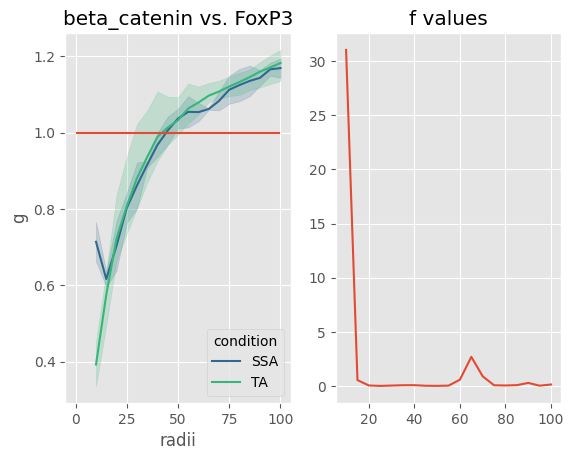

In [21]:
plot = space_analysis.plot_spaceANOVA_function(
                                 stat = 'g', 
                                 comparison = "beta_catenin___FoxP3", 
                                 seed = 42, 
                                 f_stat = 'f', 
                                 hline = 1,
                                 output_directory = None)

One of the celltype in this comparison -- beta_catenin___immune -- is only present in one condition! Will not plot f statistic!


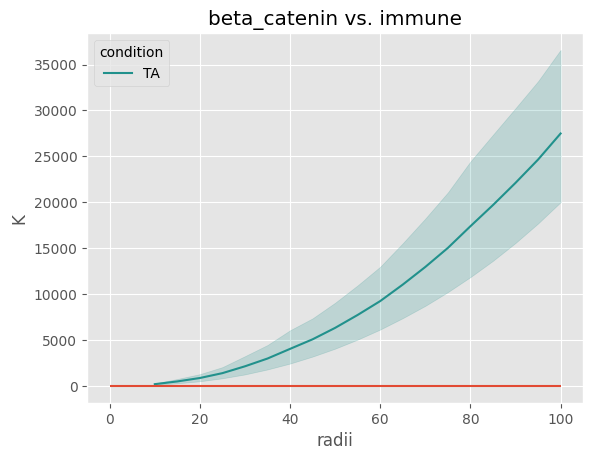

In [22]:
''' Note how only one condition has a curve and not f values -- this is because the other condition did not pass 
the cell threshold in any of its images for the collagen celltype. This also why the "immune" cell type is not
present in the functional ANOVA results.


'''

figure = space_analysis.plot_spaceANOVA_function(comparison = "beta_catenin___immune", seed = 42, stat = 'K', f_stat = 'f', hline = 1)

## Run Functional ANOVAs

Running the functional ANOVA after the Ripley's statistics are calculated is fairly straightforward:

    1). Choose the Ripley statistic to use (usually g)

    2). Choose a random seed (default = the seed selected when runinng the Ripley's statistics). This is needed because the functional ANOVA itself (oneway_anova from the scikit-fda library) needs a seed.

When completed, a set of three dataframes are made (one for the three statistics: adjusted pvalue, pvalue, and statistic). 
The p value adjustment is by the Benjamini-Hochberg False Discovery Rate correction for multiple comparisons.

The statistic (fstat) is the sampling statistic outputted by the functional ANOVA -- its significance is not the same as the f statistic 
in a traditional ANOVA (its value does not correspond with the p value as far as I can tell). I export it here for completeness,
in case experts in this statistical test may find it useful.

In [23]:
padj, p, stat = space_analysis.run_SpaceANOVA_statistics('g', 42)
padj

,beta_catenin,CD4,CD20,CD8,CD11b,CD68,collagen,p_selectin,FoxP3
beta_catenin,0.7652,0.8189,0.8381,0.6834,0.5909,0.5909,0.7997,0.8189,0.8768
CD4,0.8189,0.8189,0.6831,0.5909,0.5909,0.7997,0.5909,0.8189,0.5909
CD20,0.9030,0.6849,0.7391,0.6831,0.8189,0.8189,0.7652,0.5909,0.7391
CD8,0.7380,0.5909,0.6834,0.8189,0.8494,0.5909,0.7997,0.7336,0.5909
CD11b,0.5909,0.5909,0.8189,0.8494,0.8319,0.7901,0.5909,0.7391,0.7391
CD68,0.5909,0.8189,0.8189,0.5909,0.7901,0.5909,0.6831,0.8650,0.8189
collagen,0.7997,0.5909,0.7652,0.7901,0.5909,0.6831,0.6849,0.6831,0.8189
p_selectin,0.8189,0.8189,0.5909,0.6831,0.7391,0.8189,0.6831,0.7901,0.5909
FoxP3,0.8756,0.5909,0.7391,0.5909,0.7391,0.8189,0.8189,0.6269,0.7391


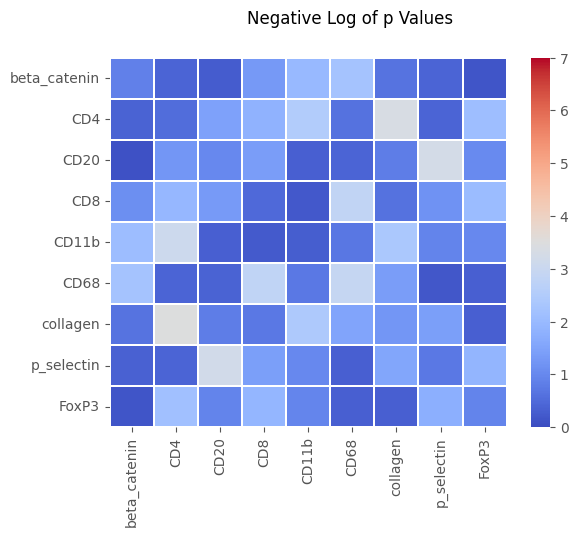

In [24]:
space_analysis.plot_spaceANOVA_heatmap('p', filename = "SpaceANOVA_heatmap")

## Spatial Euclidean Distance Transform

Calculate the distance from each mask to a particular pixel classification. This is done by calculating
a euclidean distance transfrom (edt) for each pixel class in a pixel classifier's output, then calculating 
a summary statistic from the mask regions on the edt map (just like calculating the region measurements for
any of the traditional channels in an image). 

This derives a value of the average or minimum distance from the pixel class for every cell in the dataset, which can be added
to the data as if it was another channel, with its own marker_class.

Important parameters:

    1). & 2). pixel classification and masks folders
    
    3). smoothing -- if > 0, used to remove isolated instances of pixel classes. If used, this is intended to reduce the effect of extremely small regions of the pixel class, by removing many of those regions
    The smoothing applied is similar to the smoothing available when training/predicting from an unsupervised classifier

    4). stat -- what aggregate statistic to use when measuring from cell regions. Usually either "mean" for average distance or "min" for minimum distance from cells to the pixel class
    "median" is also possible.

    5). normalized (only used if stat is 'mean' or 'median') -- whether to divide the average of the cell by the average of the entire image that it is in. This helps control for when a pixel class is 
    much more abundant in one image vs. another.

    6). background -- whether to include background as one of the pixel classes to calculate edt values for. Default = False, but sometimes (like this case) the background class is associate
    with a meaningful biological label.

    7). marker_class -- what marker_class to associate with this antigen (see Analysis_panel or Analysis.data.var to see the usual marker_classes: type,state, none). If there are more than one pixel class in a classifier's output, they will all be given the same marker_class (whatever is provided here). The default is 'spatial_edt' because usually you will want to plot the edt values separately from the traditional antigen markers. Additionally, the plotting / statistics methods for edt data that will be shown immediately after this are, by default, specific to this 'spatial_edt' marker_class. 
        However, as an example of alternate marker_class: you could choose a marker_class of 'type' and then use the edt values A). as part of cell clustering with FlowSOM and B). plot the edt values in the same plots as the traditional markers that are also of the same 'type' marker_class. 


It is possible to load more than one edt from more than one pixel classifier's outputs. If the classes should be strictly non-overlapping (as is the case here), than one pixel classifier should be enough. However, if each pixel class could overlap -- for example, if each class is meant to represent the distance to a different Extracellular Matrix protein, and these proteins can coexist in the same location in the tissue -- then it is better to make individual classifiers for each target class, and then load the edt data for each one-by-one by calling the do_edt method for each. 

In [25]:
''' Because I dropped cells for spaceANOVA, I will now reload the experiment to restore the dropped cells '''

''' To reload, create  a new Analysis in the same directory and repeat any scaling / cluster loading steps '''
Analysis_experiment = pbug.Analysis()
Analysis_experiment.load_data(ImageAnalysis.directory_object.Analysis_internal_dir) 

merging_name = 'merging'
Analysis_experiment.do_scaling("%quantile")    ## loading a saved clustering requires that the data matches, so the scaling of the data when the annotation was saved needs to be applied before loading the data.
                                               ## The data scaling can be changed after loading the clustering
Analysis_experiment.load_clustering(ImageAnalysis.directory_object.Analysis_internal_dir + f"/clusterings/{merging_name}.csv")

'''Then connect the SpatialAnalysis object to the new Analysis '''
space_analysis.add_Analysis(Analysis_experiment)

In [26]:
space_analysis.do_edt(pixel_classifier_folder = f"{project_directory}/Pixel_Classification/lumen_epithelia_laminapropria", 
                        masks_folder = f"{project_directory}/masks/example_deepcell_masks", ## again, this is used for replicability with masks
                        smoothing = 10, 
                        stat = 'mean', 
                        normalized = True,
                        background = True,    ## because for this classifier background represents something ('lumen'). Set to False by default
                        marker_class = 'spatial_edt')

(                                          fcs_colnames  \
 antigen                                                  
 distance to background          distance to background   
 distance to epithelia            distance to epithelia   
 distance to lamina_propria  distance to lamina_propria   
 
                                                antigen marker_class  
 antigen                                                              
 distance to background          distance to background  spatial_edt  
 distance to epithelia            distance to epithelia  spatial_edt  
 distance to lamina_propria  distance to lamina_propria  spatial_edt  ,
        distance to background  distance to epithelia  \
 0                    1.928277               2.282109   
 1                    0.317124               0.020194   
 2                    2.628931               2.553191   
 3                    0.643616               0.000000   
 4                    0.951623               0.000000   
 ... 

C:\Users\benca\miniforge3\envs\main\lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
C:\Users\benca\miniforge3\envs\main\lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


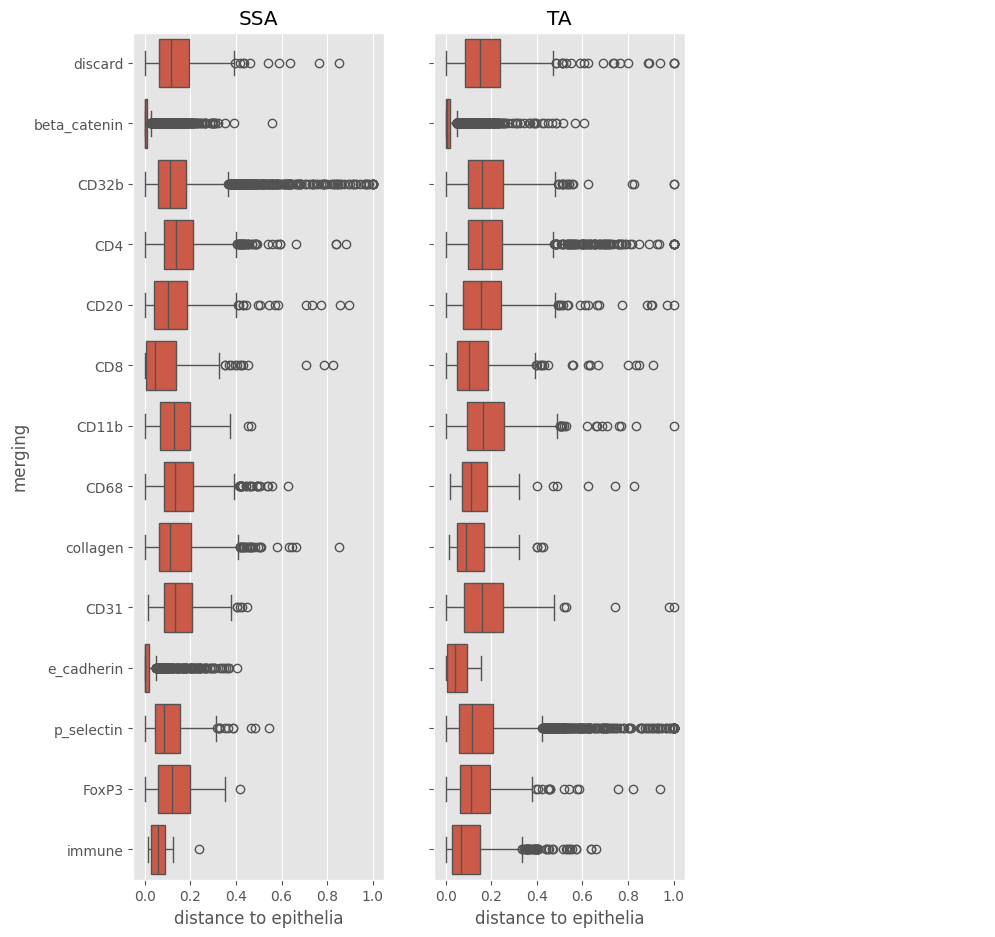

In [27]:
''' Remember that higher values on the boxplot indicates further distances from the pixel class  '''

space_analysis.plot_edt_boxplot('distance to epithelia', filename = "EDT_boxplot")

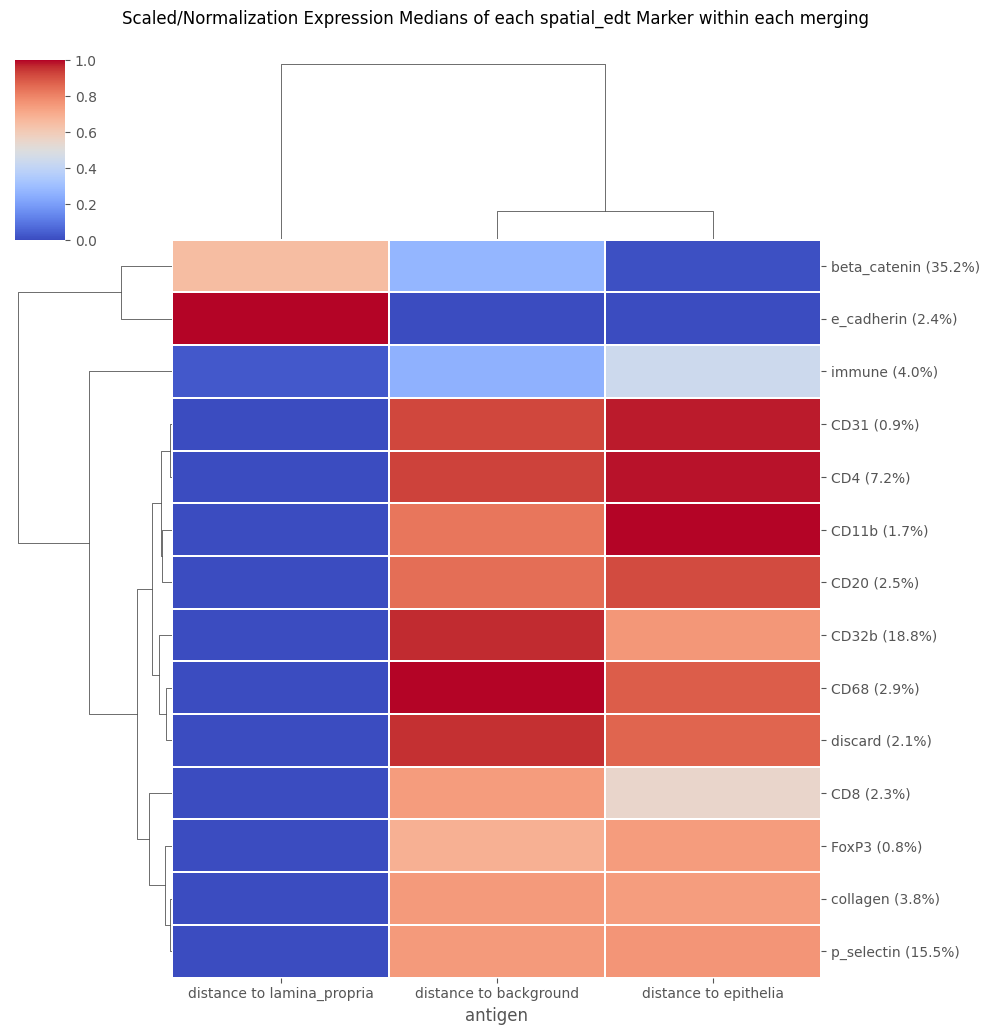

In [28]:
''' This plotting method depends on there being >1 set of edt values loaded, and will throw an error if there is only 1!  '''

space_analysis.plot_edt_heatmap('merging', filename = "EDT_heatmap")

In [29]:
''' This just runs a basic ANOVA / or Kruskal-Wallis test comparing the aggregated edt distributions in ROIs between the conditions in the data. 
As in, it takes the mean or median of the edt values for each celltype in each image, and then uses the distribution of those averages per celltype
to run a statistical test between the two conditions.

By default, it uses the mean to aggregate and runs an ANOVA test. 
'''

space_analysis.run_edt_statistics('merging', filename = "edt_stats")

,antigen,merging,p_value,p_adj,F statistic,avg SSA mean exprs,SSA avg stdev,avg TA mean exprs,TA avg stdev
28,distance to lamina_propria,CD11b,0.003457,0.1452,16.780000,0.005380,0.005380,0.019760,0.005531
17,distance to epithelia,CD32b,0.023350,0.3413,7.816000,0.146400,0.027790,0.189300,0.015050
27,distance to epithelia,p_selectin,0.035150,0.3413,6.410000,0.118600,0.016680,0.150700,0.023740
22,distance to epithelia,beta_catenin,0.037460,0.3413,6.205000,0.009471,0.007083,0.020130,0.005792
24,distance to epithelia,discard,0.041040,0.3413,5.917000,0.132700,0.023480,0.200700,0.063950
30,distance to lamina_propria,CD31,0.048750,0.3413,5.393000,0.006522,0.009925,0.057200,0.053710
16,distance to epithelia,CD31,0.069790,0.3723,4.377000,0.131900,0.048720,0.214600,0.077700
34,distance to lamina_propria,CD8,0.071030,0.3723,4.330000,0.031260,0.018360,0.011760,0.000546
14,distance to epithelia,CD11b,0.088110,0.3723,3.770000,0.141000,0.014960,0.183300,0.051620
40,distance to lamina_propria,immune,0.091560,0.3723,3.674000,0.013310,0.024800,0.050710,0.037570
